## Sberbank data analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We load the training data, test data and macro file.

In [2]:
train = pd.read_csv('train.csv/train.csv', parse_dates=['timestamp'])
test = pd.read_csv('test.csv/test.csv', parse_dates=['timestamp'])
macro = pd.read_csv('macro.csv', parse_dates=['timestamp'])

In [3]:
print(train.shape)

(30471, 292)


In [4]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


During the competition, it was discovered that some entries in the data were wrong. A fix was provided for this.

In [5]:
fix_csv = pd.read_csv('BAD_ADDRESS_FIX.csv')
print('Loaded fix data.')

Loaded fix data.


We replace the wrong data with the new information.

In [6]:
initial_columns1 = train.columns.tolist()
initial_columns2 = test.columns.tolist()

train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

print('Number of fixes:', fix_csv.shape[0])
fix_csv.drop_duplicates(subset='id', inplace=True)
print('Remaining number of fixes:', fix_csv.shape[0])
fix_csv.set_index('id', inplace=True)

print('Test shape before:', test.shape)

N = train.shape[0]
together = pd.concat([train, test])
together.loc[fix_csv.index, fix_csv.columns] = fix_csv
train = together[:N].copy()
test = together[N:].copy()
test.drop("price_doc", axis=1, inplace=True)

print('Test shape after:', test.shape)

train.reset_index(inplace=True)
test.reset_index(inplace=True)

train = train[initial_columns1]
test = test[initial_columns2]

Number of fixes: 699
Remaining number of fixes: 699
Test shape before: (7662, 290)
Test shape after: (7662, 290)


The test data follows the train data in time.

In [7]:
print('Start date train:', train.timestamp.min())
print('End date train:', train.timestamp.max())
print('Start date test:', test.timestamp.min())
print('End date test:', test.timestamp.max())

Start date train: 2011-08-20 00:00:00
End date train: 2015-06-30 00:00:00
Start date test: 2015-07-01 00:00:00
End date test: 2016-05-30 00:00:00


We plot the price of the apartments.

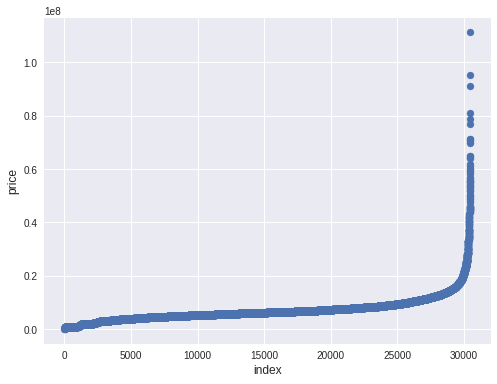

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

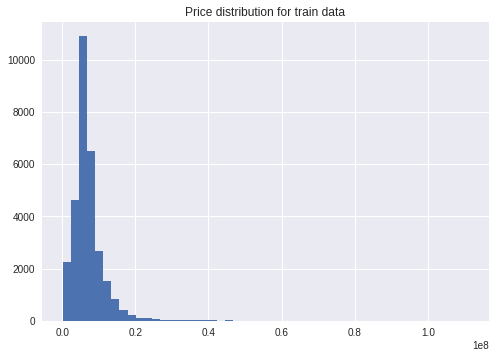

In [9]:
plt.hist(train.price_doc, bins=50)
plt.title('Price distribution for train data')
plt.show()

We also plot the price according to time.

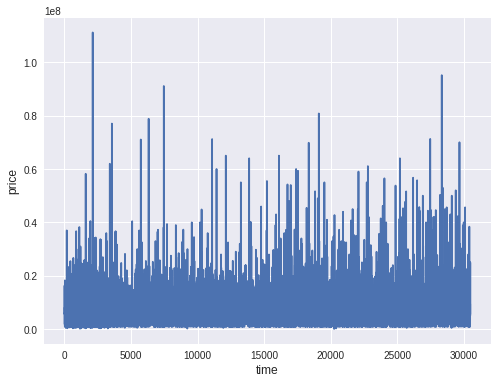

In [10]:
plt.figure(figsize=(8,6))
plt.plot(range(train.shape[0]), train.price_doc.values)
plt.xlabel('time', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

Let us see how many missing values we have in each column. We first make a simple plot to get a rough idea.

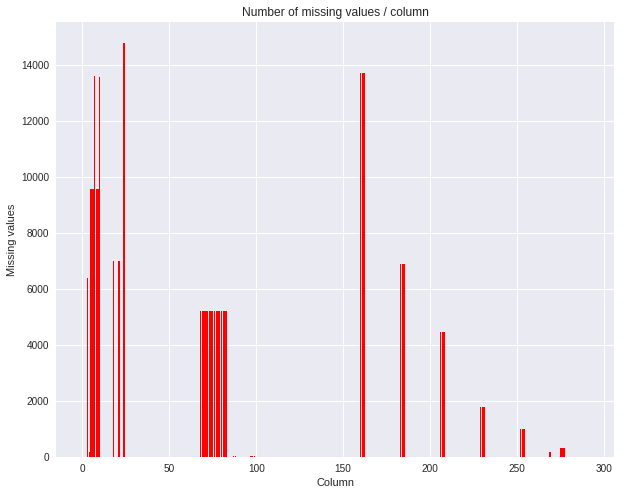

In [11]:
train_null = train.isnull().sum(axis=0)
N = train.shape[1]
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(np.arange(N), train_null, color='r')
ax.set_ylabel('Missing values')
ax.set_xlabel('Column')
ax.set_title('Number of missing values / column')
plt.show()

It seems there are a few columns missing more than 2000 values.

In [12]:
train_null_large = train_null[train_null > 2000]
print(train_null_large)

life_sq                                   6383
max_floor                                 9572
material                                  9572
build_year                               13605
num_room                                  9572
kitch_sq                                  9572
state                                    13559
preschool_quota                           7000
school_quota                              6997
hospital_beds_raion                      14792
raion_build_count_with_material_info      5225
build_count_block                         5225
build_count_wood                          5225
build_count_frame                         5225
build_count_brick                         5225
build_count_monolith                      5225
build_count_panel                         5225
build_count_foam                          5225
build_count_slag                          5225
build_count_mix                           5225
raion_build_count_with_builddate_info     5225
build_count_b

### Data cleaning

We fix some quality issues in the data.

#### State

First note that there is a spurious entry in the state column.

In [13]:
print('Values for state:', train.state.unique())
print('Number of times 33 appears:', (train.state==33).sum())
print('We replace 33 by', train.state[train.state < 33].max())
train.loc[train.state == 33, 'state'] = train.state[train.state < 33].max()

Values for state: [ nan   3.   1.   2.   4.  33.]
Number of times 33 appears: 1
We replace 33 by 4.0


#### Build year

The build year contains several strange values: 0, 1, 3, 20, 71, 215, 1691, 4965 and 20052009.

We decide that 4965 is in fact an input error: it should have been 1965.
We replace 20052009 with the mean, 2007.

Similarly, we replace 215 by 2015, and 71 by 1971.

Finally, 1691 is most likely 1961.

In [14]:
train.loc[train.build_year == 4965, 'build_year'] = 1965
train.loc[train.build_year == 20052009, 'build_year'] = 2007
train.loc[train.build_year == 215, 'build_year'] = 2015
train.loc[train.build_year == 71, 'build_year'] = 1971
train.loc[train.build_year == 1691, 'build_year'] = 1961

There are also several entries where build_year was wrongly inserted as kitch_sq.

In [15]:
train[train.kitch_sq >= 1000]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
10368,10371,2013-09-10,79.0,41.0,5.0,17.0,6.0,2013.0,3.0,2013.0,...,0,0,0,1,7,1,0,12,1,7281225.0
13117,13120,2013-12-14,31.0,19.0,5.0,1.0,1.0,NaN,1.0,1970.0,...,27,5,0,27,44,0,12,117,12,3650000.0
21415,21418,2014-08-11,43.0,43.0,3.0,1.0,1.0,2014.0,1.0,2014.0,...,2,2,0,0,12,1,0,6,1,3801200.0
28734,28737,2015-03-31,31.0,16.0,2.0,12.0,5.0,1972.0,1.0,1974.0,...,0,0,0,1,2,0,2,7,2,1000000.0


For the entry with id 13120, we set build_year as kitch_sq. For the rest we clear kitch_sq.

In [16]:
train.loc[train.id == 13120, 'build_year'] = train.loc[train.id == 13120, 'kitch_sq']
train.loc[train.kitch_sq >= 1000, 'kitch_sq'] = np.NaN

/home/elwin/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/elwin/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


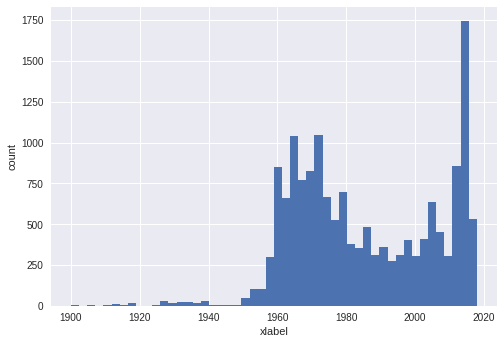

In [17]:
plt.hist(train.build_year, bins=50, range=(1900, 2018))
plt.xlabel('xlabel')
plt.ylabel('count')
plt.show()

#### Life squares

There are several entries where life_sq is well above 300, as well as higher than full_sq.

In [18]:
train[train.life_sq >= 300]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
128,129,2011-10-15,325.0,325.0,7.0,NaN,NaN,NaN,NaN,NaN,...,3,1,0,7,14,0,9,44,10,5000000.0
4385,4388,2012-10-25,73.0,426.0,17.0,NaN,NaN,NaN,NaN,NaN,...,17,8,0,14,25,0,3,88,14,11918400.0
9237,9240,2013-07-16,47.0,301.0,4.0,12.0,1.0,1973.0,2.0,6.0,...,8,1,0,5,13,0,2,30,5,5600000.0
9256,9259,2013-07-17,77.0,458.0,12.0,16.0,1.0,1996.0,3.0,10.0,...,4,0,0,5,22,0,0,18,7,13750000.0
9646,9649,2013-08-06,82.0,802.0,5.0,NaN,NaN,NaN,NaN,NaN,...,7,1,0,7,16,0,0,34,5,12031350.0
13546,13549,2013-12-30,79.0,7478.0,8.0,17.0,1.0,2014.0,3.0,1.0,...,0,0,0,1,7,1,0,12,1,7705000.0
21080,21083,2014-07-24,52.0,349.0,1.0,9.0,1.0,1979.0,3.0,6.0,...,1,1,0,2,10,0,1,11,2,7200000.0
22785,22788,2014-09-23,637.0,637.0,18.0,19.0,4.0,2016.0,2.0,10.0,...,1,0,0,1,4,0,0,4,1,4725142.0
26342,26345,2014-12-12,75.0,435.0,3.0,22.0,1.0,1999.0,3.0,9.0,...,12,3,1,5,6,0,1,32,4,12900000.0
27793,27796,2015-02-09,407.0,407.0,4.0,4.0,4.0,2015.0,1.0,10.0,...,103,57,13,22,43,1,13,121,7,3134129.0


From these one entry stands out: id 22788, where all columns have unlikely high values. This one is an outlier. We delete it.

In [19]:
train.drop(22785, inplace=True)

However, for the rest it is probable that life_sq was wrongly inputed with one digit shifted to the left.
That is, 426.0 should be 42.6, 458.0 should be 45.8, and so on. We fix this.

In [20]:
pos = (train.life_sq >= 100.0) & (train.life_sq > train.full_sq) & (train.id != 22788)
train.loc[pos, 'life_sq'] = train.loc[pos, 'life_sq']/10.0
train.loc[train.id == 13549, 'life_sq'] = 74.78 # fix special entry

We have another outlier, where full_sq is 5326. We apply the same algorithm and replace it by 53.26. We also replace several other values of full_sq that are unreasonably high.

In [21]:
train.loc[train.full_sq == 5326, 'full_sq'] /= 100.0

pos = (train.full_sq >= 250.0) & (train.full_sq >= train.life_sq * 10)
train.loc[pos, 'full_sq'] = train.loc[pos, 'full_sq'] / 10.0
pos = (train.full_sq >= 250.0) & (train.full_sq >= train.life_sq) & (train.id != 18528)
train.loc[pos, 'full_sq'] /= 10.0
train.loc[pos, 'life_sq'] /= 10.0

Let us see the relation between flat size and price.

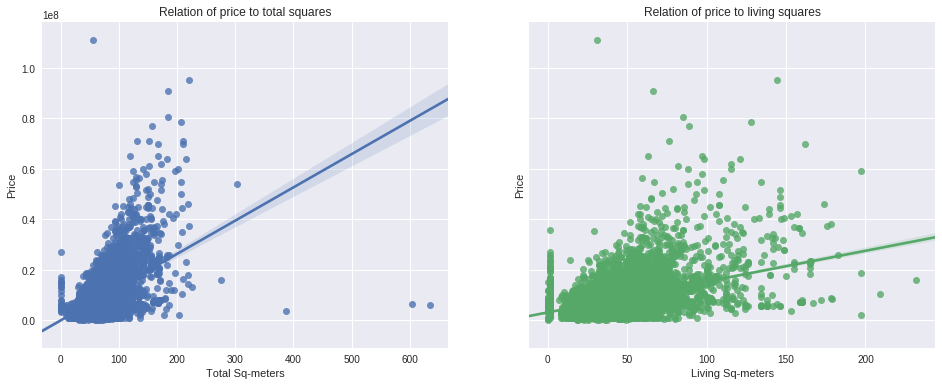

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
ax1 = sns.regplot(train.full_sq, train.price_doc, ax = ax1)
ax1.set_ylabel('Price')
ax1.set_xlabel('Total Sq-meters')
ax1.set_title('Relation of price to total squares')
ax2 = sns.regplot(train.life_sq, train.price_doc, ax = ax2)
ax2.set_xlabel('Living Sq-meters')
ax2.set_ylabel('Price')
ax2.set_title('Relation of price to living squares')
plt.show()

#### Number of rooms

In [23]:
print('Minimum number of living rooms:', train.num_room.min())
print('Maximum number of living rooms:', train.num_room.max())

Minimum number of living rooms: 0.0
Maximum number of living rooms: 19.0


There is one entry where the number of rooms is 19.

In [24]:
train[train.num_room == 19]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
11621,11624,2013-10-28,40.0,19.0,17.0,17.0,1.0,2011.0,19.0,7.0,...,1,1,0,2,11,0,0,6,0,2630000.0


As kitch_sq is 7, and life_sq is 19, it is likely that there is just 1 living room.

In [25]:
train.loc[train.id == 11624, 'num_room'] = 1.0

Then there is another entry where the number of rooms is 15.

In [26]:
train[train.num_room >= 15]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
26713,26716,2014-12-18,51.0,30.0,14.0,17.0,1.0,1984.0,17.0,8.0,...,41,4,1,6,37,1,7,84,10,13150000.0


In this case the number of living rooms should be 2.

In [27]:
train.loc[train.id == 26716, 'num_room'] = 2.0

Finally, there are 2 entries where the number of rooms seems too high in comparison with full_sq.

In [28]:
train.ix[[17764, 29172]]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
17764,17767,2014-04-23,58.0,34.0,1.0,2.0,1.0,1992.0,10.0,10.0,...,0,0,0,0,2,0,2,8,1,6000000.0
29172,29175,2015-04-16,59.0,33.0,20.0,22.0,1.0,2000.0,10.0,10.0,...,5,1,0,9,24,0,3,51,8,11000000.0


In [29]:
train.ix[[17764, 29172], "num_room"] = np.NaN

We make a histogram for the number of rooms per flat.

/home/elwin/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/elwin/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


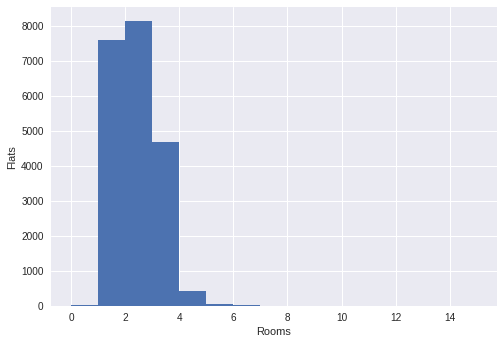

In [30]:
plt.hist(train.num_room, bins = 15, range=(0,15), histtype='bar')
plt.xlabel('Rooms')
plt.ylabel('Flats')
plt.show()

#### Purchase type

There are 2 types of purchases: made with the intent to live in the new home, and made for investment.

In [31]:
train.product_type.unique()

array(['Investment', 'OwnerOccupier'], dtype=object)

We plot the relation between price and type of purchase.

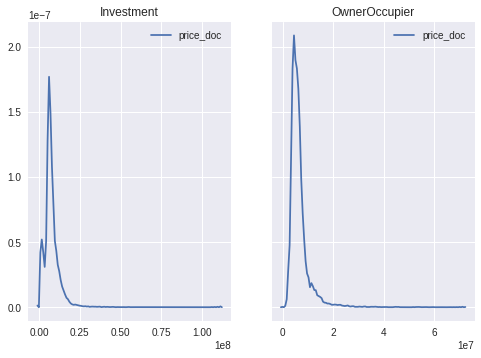

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.kdeplot(train[train.product_type == 'Investment'].price_doc, ax = ax1)
sns.kdeplot(train[train.product_type == 'OwnerOccupier'].price_doc, ax = ax2)
ax1.set_title('Investment')
ax2.set_title('OwnerOccupier')
plt.show()

#### Floor

There are many entries where the maximum floor is smaller than the apartment floor.

In [33]:
(train.max_floor < train.floor).sum()

1493

We repair these entries by setting max_floor equal to floor.

In [34]:
pos = train.max_floor < train.floor
train.loc[pos, "max_floor"] = train.loc[pos, "floor"]

### Correlations

We compute correlations between several columns.

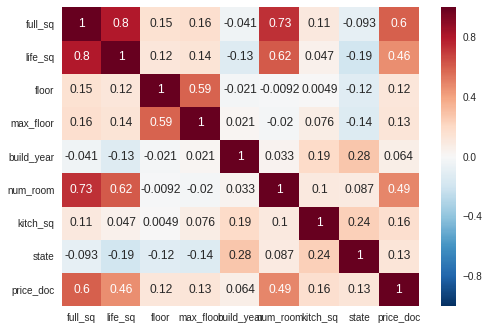

In [35]:
list_cols = ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 
            'kitch_sq', 'state', 'price_doc']
corrs = train[list_cols].corr()
sns.heatmap(corrs, annot=True)
plt.show()

We check the effect of cafe bills on price.

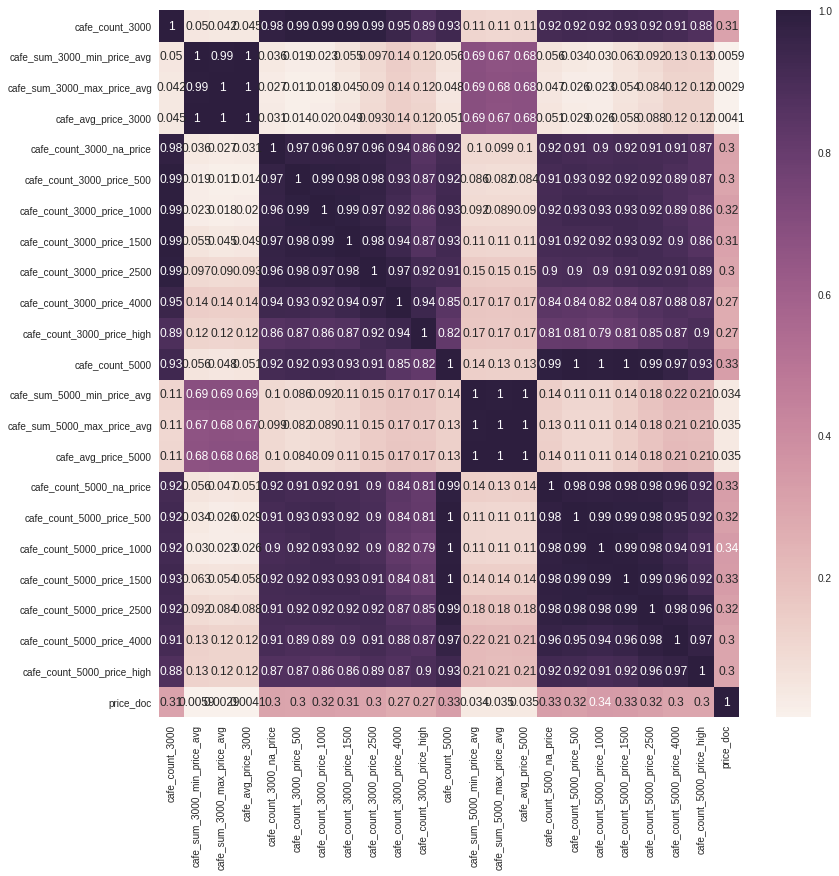

In [36]:
cafe_cols = ['cafe_count_500', 'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
             'cafe_avg_price_500', 'cafe_count_500_na_price', 'cafe_count_500_price_500',
             'cafe_count_500_price_1000', 'cafe_count_500_price_1500',
             'cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high',
             'cafe_count_1000', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg',
             'cafe_avg_price_1000', 'cafe_count_1000_na_price', 'cafe_count_1000_price_500',
             'cafe_count_1000_price_1000', 'cafe_count_1000_price_1500', 'cafe_count_1000_price_2500',
             'cafe_count_1000_price_4000', 'cafe_count_1000_price_high',
             'cafe_count_1500', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
             'cafe_avg_price_1500', 'cafe_count_1500_na_price', 'cafe_count_1500_price_500',
             'cafe_count_1500_price_1000', 'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500',
             'cafe_count_1500_price_4000', 'cafe_count_1500_price_high',
             'cafe_count_2000', 'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg',
             'cafe_avg_price_2000', 'cafe_count_2000_na_price', 'cafe_count_2000_price_500',
             'cafe_count_2000_price_1000', 'cafe_count_2000_price_1500', 'cafe_count_2000_price_2500',
             'cafe_count_2000_price_4000', 'cafe_count_2000_price_high',
             'cafe_count_3000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
             'cafe_avg_price_3000', 'cafe_count_3000_na_price', 'cafe_count_3000_price_500',
             'cafe_count_3000_price_1000', 'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500',
             'cafe_count_3000_price_4000', 'cafe_count_3000_price_high',
             'cafe_count_5000', 'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg',
             'cafe_avg_price_5000', 'cafe_count_5000_na_price',
             'cafe_count_5000_price_500', 'cafe_count_5000_price_1000',
             'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500',
             'cafe_count_5000_price_4000', 'cafe_count_5000_price_high']
corrs = train[cafe_cols[44:66] + ['price_doc']].corr()
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(corrs, annot=True, ax = ax)
plt.show()

Interestingly, it turns out the higher the radius the stronger the correlation is between cafe bill and price. The best
predictors are the cafe\_count\_5000\_ columns.

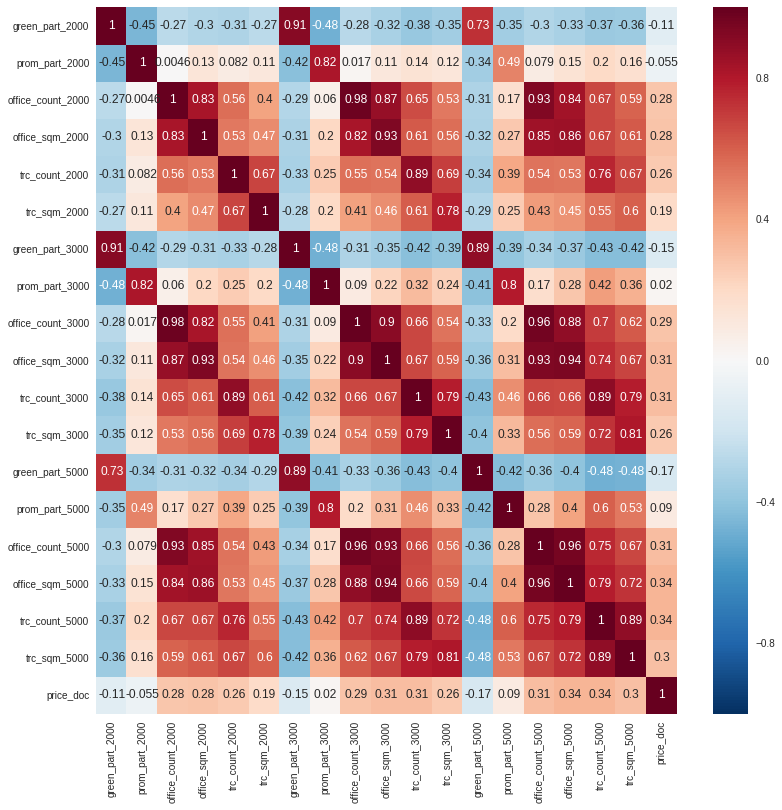

In [37]:
zones_cols = ['green_part_500', 'prom_part_500', 'office_count_500', 'office_sqm_500','trc_count_500','trc_sqm_500',
              'green_part_1000', 'prom_part_1000', 'office_count_1000', 'office_sqm_1000', 'trc_count_1000', 'trc_sqm_1000',
              'green_part_1500', 'prom_part_1500', 'office_count_1500', 'office_sqm_1500', 'trc_count_1500', 'trc_sqm_1500',
              'green_part_2000', 'prom_part_2000', 'office_count_2000', 'office_sqm_2000', 'trc_count_2000', 'trc_sqm_2000',
              'green_part_3000', 'prom_part_3000', 'office_count_3000', 'office_sqm_3000', 'trc_count_3000', 'trc_sqm_3000',
              'green_part_5000', 'prom_part_5000', 'office_count_5000', 'office_sqm_5000', 'trc_count_5000', 'trc_sqm_5000']
corrs = train[zones_cols[18:] + ['price_doc']].corr()
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(corrs, annot=True, ax = ax)
plt.show()

Market price seems to be somewhat correlated with office count and space, but not with green or industrial areas. Again, the strongest correlations are for the 5km radius.

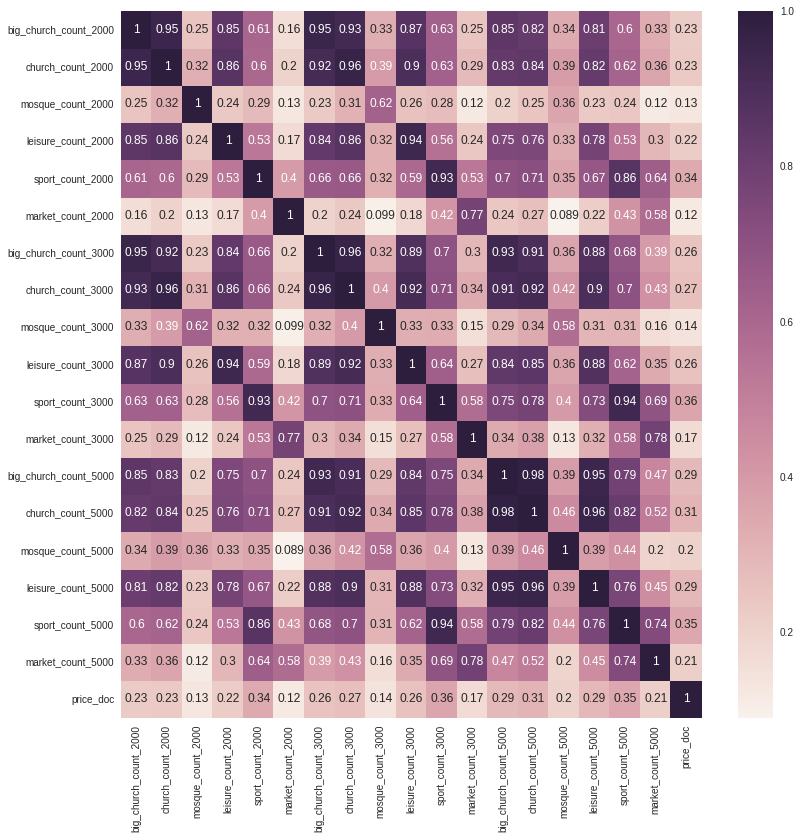

In [38]:
build_cols = ['big_church_count_500', 'church_count_500', 'mosque_count_500', 'leisure_count_500', 'sport_count_500',
              'market_count_500', 'big_church_count_1000', 'church_count_1000', 'mosque_count_1000', 'leisure_count_1000',
              'sport_count_1000', 'market_count_1000', 'big_church_count_1500', 'church_count_1500', 'mosque_count_1500',
              'leisure_count_1500', 'sport_count_1500', 'market_count_1500', 'big_church_count_2000', 'church_count_2000',
              'mosque_count_2000', 'leisure_count_2000', 'sport_count_2000', 'market_count_2000',
              'big_church_count_3000', 'church_count_3000', 'mosque_count_3000', 'leisure_count_3000',
              'sport_count_3000', 'market_count_3000', 'big_church_count_5000', 'church_count_5000', 'mosque_count_5000',
              'leisure_count_5000', 'sport_count_5000', 'market_count_5000']
corrs = train[build_cols[18:36] + ['price_doc']].corr()
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(corrs, annot=True, ax = ax)
plt.show()

Here the most import factor is the number of sports facilities, followed by churches.

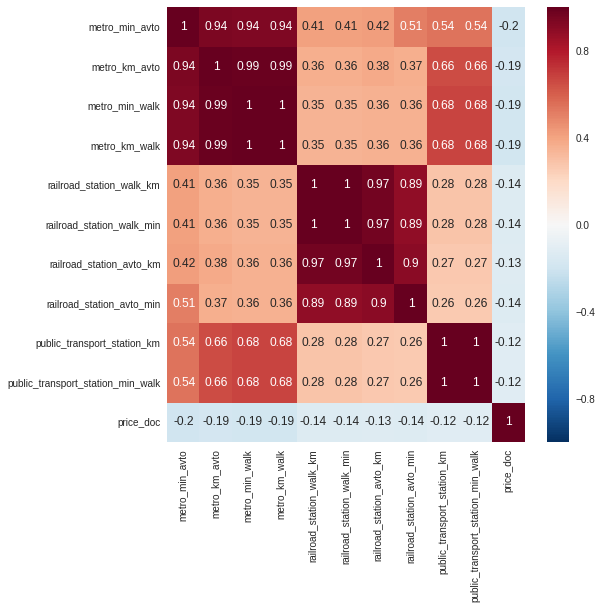

In [39]:
dist_cols = ['metro_min_avto', 'metro_km_avto', 'metro_min_walk', 'metro_km_walk',
             'railroad_station_walk_km', 'railroad_station_walk_min', 'railroad_station_avto_km',
             'railroad_station_avto_min', 'public_transport_station_km', 'public_transport_station_min_walk']
corrs = train[dist_cols + ['price_doc']].corr()
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrs, annot=True, ax = ax)
plt.show()

Distance to the nearest public transport station is not a concern.

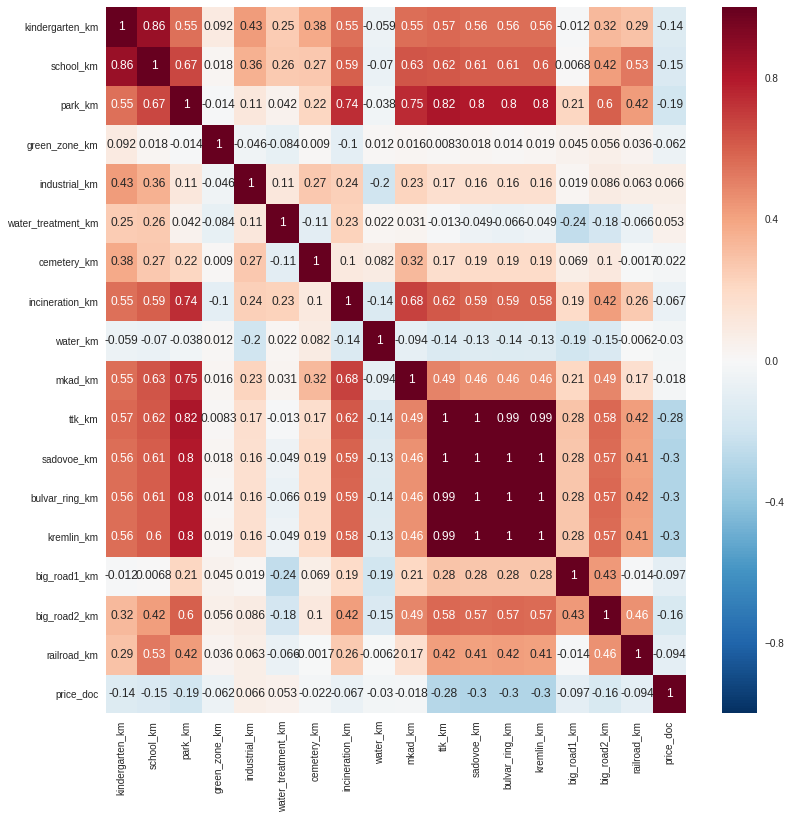

In [40]:
facilities_cols = ['kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_treatment_km',
                   'cemetery_km', 'incineration_km', 'water_km', 'water_1line', 'mkad_km', 'ttk_km', 'sadovoe_km', 
                   'bulvar_ring_km', 'kremlin_km', 'big_road1_km', 'big_road2_km', 'railroad_km']
corrs = train[facilities_cols + ['price_doc']].corr()
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(corrs, annot=True, ax = ax)
plt.show()

Distance to the city rings seems to be important.

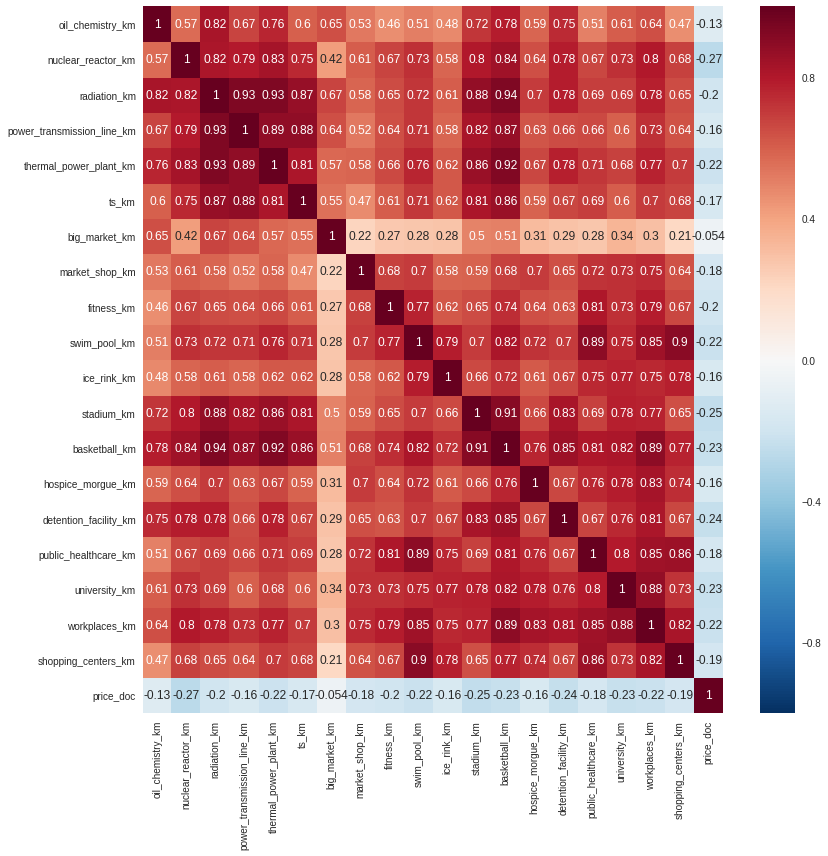

In [41]:
dist_cols2 = ['oil_chemistry_km', 'nuclear_reactor_km', 'radiation_km',
              'power_transmission_line_km', 'thermal_power_plant_km', 'ts_km',
              'big_market_km', 'market_shop_km', 'fitness_km', 'swim_pool_km', 'ice_rink_km',
              'stadium_km', 'basketball_km', 'hospice_morgue_km', 'detention_facility_km',
              'public_healthcare_km', 'university_km', 'workplaces_km', 'shopping_centers_km']
corrs = train[dist_cols2 + ['price_doc']].corr()
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(corrs, annot=True, ax = ax)
plt.show()

Again, distance to sports facilities is the most relevant.

### Categorical columns

A few of the columns are categorical. We collect them below.

In [42]:
categorical_cols = []
for c in train.columns:
    if train[c].dtype == 'object':
        categorical_cols.append(c)
print(categorical_cols)

['product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology']


Sub_area represents the name of the district.

In [43]:
print('Number of districts:', len(train.sub_area.unique()))

Number of districts: 146


Ecology gives a rating of how ecological the zone is.

In [44]:
train.ecology.unique()

array(['good', 'excellent', 'poor', 'satisfactory', 'no data'], dtype=object)

The rest of the columns are all yes / no variables.

### Time analysis

Let us see how many purchases were carried every year.

In [45]:
train['year'] = train.timestamp.dt.year
train.groupby('year').size()

year
2011      753
2012     4839
2013     7978
2014    13661
2015     3239
dtype: int64

It looks like most of them were in 2014, although the train data only contains the first half of 2015.

We compute the month and the year as an index.

In [46]:
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 13)
train['month_year'] = month_year
train[['month_year', 'timestamp']].head()

,month_year,timestamp
0,26151,2011-08-20
1,26151,2011-08-23
2,26151,2011-08-27
3,26152,2011-09-01
4,26152,2011-09-05


In [47]:
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 53)
train['week_year'] = week_year
train[['week_year', 'timestamp']].head()

,week_year,timestamp
0,106616,2011-08-20
1,106617,2011-08-23
2,106617,2011-08-27
3,106618,2011-09-01
4,106619,2011-09-05


In [48]:
train['month'] = train.timestamp.dt.month
train['day_week'] = train.timestamp.dt.dayofweek

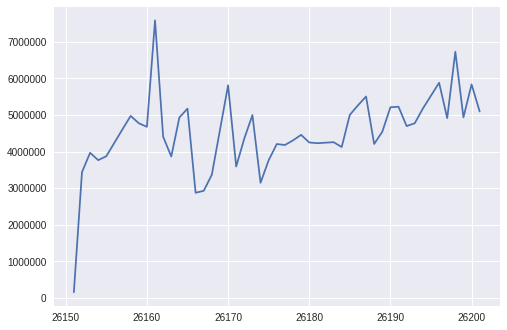

In [49]:
plt.plot(train.groupby('month_year').price_doc.std())
plt.show()

### Additional columns

We compute the price per square-meter.

In [50]:
train[train.full_sq.isnull() | (train.full_sq == 0)] = train.full_sq.median()
train['price_sq'] = train.price_doc / train.full_sq

We also compute some relative measures.

In [51]:
pos = (train.max_floor > 0)
train.loc[pos, 'rel_floor'] = train.loc[pos, 'floor'] / train.loc[pos, 'max_floor']
train.loc[~pos, 'rel_floor'] = 0.0

pos = (train.full_sq > 0)
train.loc[pos, 'rel_kitch_sq'] = train.loc[pos, 'kitch_sq'] / train.loc[pos, 'full_sq']
train.loc[~pos, 'rel_kitch_sq'] = 0.0

pos = (train.num_room > 0)
train.loc[pos, 'room_size'] = train.loc[pos, 'life_sq'] / train.loc[pos, 'num_room']
train.loc[~pos, 'room_size'] = 0.0

We take the log of the price.

In [52]:
train['price_log'] = np.log(train['price_doc'])